# How first-time airbnb users decide where to travel
***

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

### Airbnb challenges you to predict in which destination country a new user from the USA will make his or her first booking:
1. United States of America
2. France
3. Canada
4. Great Britain
5. Estonia
6. Italy
7. Portugal
8. Netherlands
9. Germany
10. Australia  
11. No Destination Found (NDF) 
12. Other


### Known issues
1. before early 2013 users could make bookings without creating an account
2. where *date_first_booking* is populated with *NAN* the destination country is also given as NDF


### Questions that I would like to explore using the summary data provided are:
1. Are there missing data or data munging that need to be done?
2. Are there any outliers?
3. What are the similarities/differences in the destination countries?
4. Demographic differences that could point to preferences?
5. Investigate the impact that user interaction with the website has on destination selection.

In [2]:
# load libraries that will be used
%matplotlib inline

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from mpl_toolkits.basemap import Basemap

C:\Miniconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# unzip and read data

# Dataset #1: Countries to visit
zf = zipfile.ZipFile('data/countries.csv.zip')
countries = pd.read_csv(zf.open('countries.csv'))

# Dataset #2: Compare demographic distributions within destination countries
zf = zipfile.ZipFile('data/age_gender_bkts.csv.zip')
country_demographics = pd.read_csv(zf.open('age_gender_bkts.csv'))

# Dataset #3: User interactions on airbnb website
zf = zipfile.ZipFile('data/sessions.csv.zip')
user_sessions = pd.read_csv(zf.open('sessions.csv'))

# Dataset #4: Comparing test and training data to what has been provided as user data for 2015
# train
zf = zipfile.ZipFile('data/train_users_2.csv.zip')
train = pd.read_csv(zf.open('train_users_2.csv'))

# test
zf = zipfile.ZipFile('data/test_users.csv.zip')
test = pd.read_csv(zf.open('test_users.csv'))

# concatenate train- and test users together for total sample
users = pd.concat((train, test), axis=0, ignore_index=True)

***
## Ten potential countries to explore, which are they more likely to choose?

In [4]:
# let's take a look at the country data provided
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


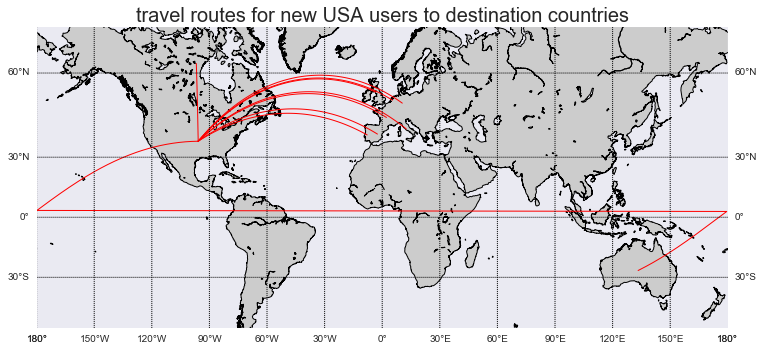

In [5]:
# create new figure, axes instances.
fig=plt.figure(figsize=(12,9))
ax=fig.add_axes([0.1,0.1,0.8,0.8])

# setup mercator map projection as map background
m = Basemap(llcrnrlon=-180.,llcrnrlat=-50.,urcrnrlon=180.,urcrnrlat=70.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)

# draw great circle route between USA and destination countries
dest_lon = countries.lng_destination
dest_lat = countries.lat_destination
usa_lon = dest_lon[9]
usa_lat = dest_lat[9]
destinations = len(countries.country_destination)-1 # minus one in order to exclude USA at the end
for i in range(destinations):
    m.drawgreatcircle(usa_lon, usa_lat, dest_lon[i], dest_lat[i], linewidth=1, color='r')

# draw map details
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(-60,90,30),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

ax.set_title('travel routes for new USA users to destination countries', size=20)
plt.show()

The above picture highlights the fact that the majority, 7 out of the 10 destination coutries, lie within the Europe. Part of the appeal of going to at least 6 out of the 10 countries is that they are all within the European Union which makes it easy to move between the countries, as well as having the same currency. This brings up the possiblity that the choosen destination country might be favoured as a starting point for a trip around Europe and with the idea of staying in a country for the whole duration of the trip.

On the other side of the spectrum, I would group the USA, Canada and Australia under the umbrella of being large countries with lots to explore so you would tend to stay within these countries for the duration of the trip and not venture to other countries as part of the trip. Canada could be of interest to an American tourist because of it's proximity and the linked currency means there is no exchange rate risk to bump up the budgeted cost of a trip. Canada also hold a lot of natural splendour and you could practice your French in Montreal. Australia on the other hand is the only country from the southern hemisphere and could hold appeal beacuse of it's exotic wild life, beaches and more. Likewise the USA hold many attractions and most Americans tend to holiday within their own country.

According to [data](http://travel.trade.gov/view/m-2015-O-001/index.html) released by the U.S. Department of Commerce, International Trade Administration, National Travel and Tourism Office (NTTO) on 29 December 2015; 61,322,698 U.S. citizens traveled to international regions in the first 10 months of 2015. About 54.9% was to either Mexico (22,641,533 U.S. citizens; 36.9% of total) and Canada (11,008,848; 18%). All of Europe saw just above the number of U.S. citizens as Canada (11,067,879; 18% of total), but half that of Mexico and Oceania (used as proxy for Australia in this example) saw 0.8% (511,563) of U.S. citizens come to their shores in 2015. 

Based on this supporting data, my hunch is that U.S. Citizens are more likely to favour Canada and European countries to Australia. And with 458.3 million business trips and 1,692.8 million leisure trips by U.S. citizens in [2015](http://www.statista.com/statistics/207103/forecasted-number-of-domestic-trips-in-the-us/), I'm confident that domestic travel within the USA would hold great appeal to USA users of airbnb as well. 

***
## How do the demographics within countries differ between countires? 

In [7]:
# get a better feel for the underlying values within the demographics dataset
for column in country_demographics[['age_bucket','country_destination','gender','year']]:
    print(country_demographics[column].unique())

['100+' '95-99' '90-94' '85-89' '80-84' '75-79' '70-74' '65-69' '60-64'
 '55-59' '50-54' '45-49' '40-44' '35-39' '30-34' '25-29' '20-24' '15-19'
 '10-14' '5-9' '0-4']
['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NL' 'PT' 'US']
['male' 'female']
[ 2015.]


So it looks like this dataset is a summary of gender and age band per destination country as at 2015. The source is unclear, but it ties up with what I've found through Google searches.

But what else can it tell us?

C:\Miniconda\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


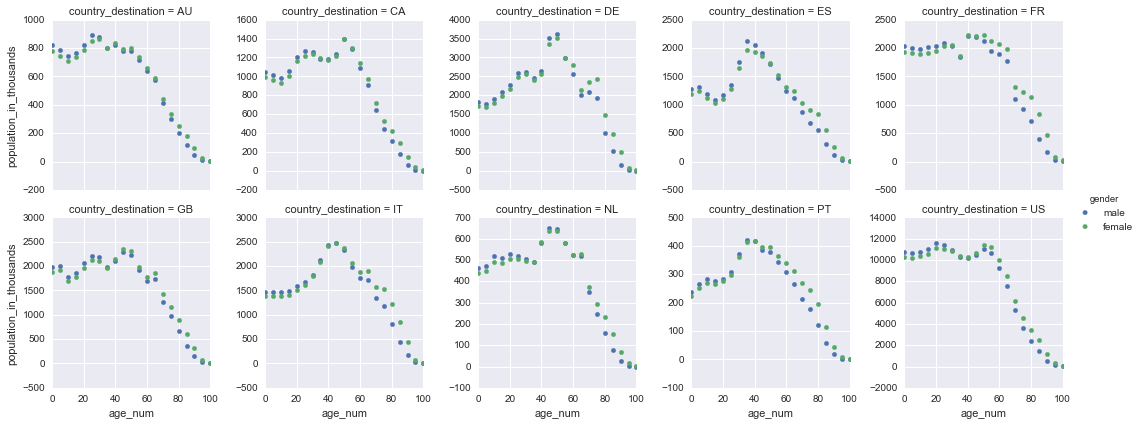

In [8]:
country_demographics['age_num'] = country_demographics['age_bucket'].map(lambda x: int(x[:str.find(x,'-')]))

g = sns.FacetGrid(country_demographics, col="country_destination", hue="gender", 
                    col_wrap=5, xlim=[0,100] ,sharey=False)
g = g.map(plt.scatter, "age_num", "population_in_thousands")
g.add_legend();

It's not clear at this stage what value these country relasted demorgaphics will have on whether users choose a specific country. But from the distribution of dots above it is clear that the highest proportion of people are in the 40 to 59 age range, but Cananda, Great Britian, and the USA have a two "humps" (bi-modal distrubtion) with significant proportion of the population in the 20 to 24 age band. While the largest portion of Australia's population sit in the 20-24 bracket. 

Gender distributions also rend to be quite similar and females tend to outlive males between the ages of 60 to 99. 

***
## What does user engagement on the airbnb website look like?

In [10]:
print("Rows: %0.0f; Columns: %0.0f" % np.shape(user_sessions))
user_sessions.tail()

Rows: 10567737; Columns: 6


,user_id,action,action_type,action_detail,device_type,secs_elapsed
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624
10567736,9uqfg8txu3,show_personalize,data,user_profile_content_update,Windows Desktop,1221


The session data seems to hold a rich variety of metrics, but they aren't really well populated (please see below) for action type and action detail with about 20.4% of these field values being populated with "-unknown-". And it would seems like unknowns in action type would also mean unknowns in action detail. But these revelance of thes fields are unclear.

In [12]:
sessions_nan = user_sessions.replace('-unknown-', np.nan)
sessions_nan_counts = sessions_nan.isnull().sum().sort_values(ascending=False)
sessions_nan_summary = (sessions_nan_counts / sessions_nan.shape[0]) * 100

print('% of rows with missing values')
print('-----------------------------')
print(sessions_nan_summary)

% of rows with missing values
-----------------------------
action_type      20.414721
action_detail    20.414446
device_type       1.999283
secs_elapsed      1.287229
action            0.753482
user_id           0.326428
dtype: float64


As the name suggests, there is more detail under the *action_detail* field about the action performed but very little other than the occurance of reservation as a description pops out as relevant. It seems action and action details both hold the same information for these two booking related action types. However, *action_type* looks like it should be the most promising since it is only 0.75% incomplete and there is direct mention of *booking_request* and *booking_response*. But on taking a closer look (see below), it was revealed that that *booking_request* and *booking_response* only represent 18,777 rows, or 0.18% of user session rows, or 6.81% of the 275,562 new users that form the combined test and train sets (assuming that each book record represents a booking per user).

In [14]:
# What values do action types tend to hold?
sessions_nan_counts = user_sessions.action_type.value_counts() 
sessions_nan_summary = (sessions_nan_counts / user_sessions.shape[0]) * 100

print('Number  of rows with missing values')
print('-------------------------------------')
print(sessions_nan_counts)
print('')
print('% of rows with missing values')
print('-------------------------------------')
print(sessions_nan_summary)

Number  of rows with missing values
-------------------------------------
view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

% of rows with missing values
-------------------------------------
view                33.695975
data                19.907479
click               18.889408
-unknown-            9.757718
submit               5.898680
message_post         0.824235
partner_callback     0.181042
booking_request      0.177644
modify               0.010778
booking_response     0.000038
Name: action_type, dtype: float64


A feature onth the other hand is populated quite well is the type of device that was used to interact with the airbnb website, and it indicates that the majority, 59.43%, of users tended to use their desktop, and a further 26.5% use a Apple mobile device.

In [15]:
user_sessions.groupby('device_type').size().sort_values(ascending=False) / user_sessions.shape[0] *100

device_type
Mac Desktop                         34.011880
Windows Desktop                     25.157127
iPhone                              19.919411
Android Phone                        7.945287
iPad Tablet                          6.466985
Android App Unknown Phone/Tablet     2.589504
-unknown-                            1.999283
Tablet                               1.323708
Linux Desktop                        0.268487
Chromebook                           0.211474
iPodtouch                            0.077576
Windows Phone                        0.019370
Blackberry                           0.009264
Opera Phone                          0.000643
dtype: float64

Looking at how long the user sessions are by device type, it looks like Blackbery and Windows Phone have the longest recorded time. This minght not be a good thing and actually point to usability issues for those that use phones that aren't Apple or Android. Android and Apple mobile devices have the lowest median session duration, while desktop and tablets see about twice the session length of mobile devices (excluding Blackberry- and Windows phones). This makes sense since the time required to plan a trip would envolve a lot of reaserach and looking at images or videos and are better suited to tablets and desktops.

In [16]:
user_sessions.groupby('device_type')['secs_elapsed'].agg(['min','mean','median','max'])\
.sort_values('median',ascending=False) / 60

,min,mean,median,max
device_type,,,,
Blackberry,0.000000,897.149771,69.658333,28251.233333
Windows Phone,0.000000,700.293252,64.583333,28407.400000
-unknown-,0.000000,426.720023,64.433333,29875.583333
iPad Tablet,0.000000,351.012478,30.133333,29986.500000
Chromebook,0.000000,393.214455,29.633333,29916.816667
Linux Desktop,0.000000,420.764027,27.391667,29579.366667
Windows Desktop,0.000000,367.968227,21.933333,29990.800000
Tablet,0.000000,274.878099,21.750000,29881.400000
Mac Desktop,0.000000,331.945146,19.883333,29999.616667


***
## Who are airbnb's first time users?
Now that we know more about where they could want to go and why and how they are interacting the website.

In [17]:
print("Number of users in the training set: %0.0f; \
Number of users in the test set: %0.0f" % (np.shape(train)[0], np.shape(test)[0]))
print("Full Set Rows: %0.0f; -Columns: %0.0f" % np.shape(users))
users.head(10)

Number of users in the training set: 213451; Number of users in the test set: 62096
Full Set Rows: 275547; -Columns: 16


,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255
1,seo,google,38,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809
2,direct,direct,56,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247
3,direct,direct,42,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129
4,direct,direct,41,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105
5,other,other,NaN,US,2010-01-01,2010-01-02,omg,Chrome,Mac Desktop,-unknown-,osr2jwljor,en,Web,0,basic,20100101215619
6,other,craigslist,46,US,2010-01-02,2010-01-05,untracked,Safari,Mac Desktop,FEMALE,lsw9q7uk0j,en,Web,0,basic,20100102012558
7,direct,direct,47,US,2010-01-03,2010-01-13,omg,Safari,Mac Desktop,FEMALE,0d01nltbrs,en,Web,0,basic,20100103191905
8,other,craigslist,50,US,2010-01-04,2010-07-29,untracked,Safari,Mac Desktop,FEMALE,a1vcnhxeij,en,Web,0,basic,20100104004211
9,other,craigslist,46,US,2010-01-04,2010-01-04,omg,Firefox,Mac Desktop,-unknown-,6uh8zyj2gn,en,Web,0,basic,20100104023758


In [18]:
# get a better feel for the underlying values within the users files
for column in users:
    print([column], users[column].unique())

(['affiliate_channel'], array(['direct', 'seo', 'other', 'sem-non-brand', 'content', 'sem-brand',
       'remarketing', 'api'], dtype=object))
(['affiliate_provider'], array(['direct', 'google', 'other', 'craigslist', 'facebook', 'vast',
       'bing', 'meetup', 'facebook-open-graph', 'email-marketing', 'yahoo',
       'padmapper', 'gsp', 'wayn', 'naver', 'baidu', 'yandex', 'daum'], dtype=object))
(['age'], array([             nan,   3.80000000e+01,   5.60000000e+01,
         4.20000000e+01,   4.10000000e+01,   4.60000000e+01,
         4.70000000e+01,   5.00000000e+01,   3.60000000e+01,
         3.70000000e+01,   3.30000000e+01,   3.10000000e+01,
         2.90000000e+01,   3.00000000e+01,   4.00000000e+01,
         2.60000000e+01,   3.20000000e+01,   3.50000000e+01,
         5.90000000e+01,   4.90000000e+01,   4.40000000e+01,
         3.40000000e+01,   2.80000000e+01,   1.90000000e+01,
         5.30000000e+01,   5.20000000e+01,   3.90000000e+01,
         5.70000000e+01,   2.50000000e+0

***
### Impact of Missing Values
There seems to be a fair amount of missing values in the test and train datasets, and three potentially important fields: *date_first_booking*, *age* and *gender* are affected.

In [50]:
# check the condition of missing vlaues across whole sample
users_nan = users.replace('-unknown-', np.nan)
users_nan_counts = users_nan.isnull().sum().sort_values(ascending=False)
users_nan_summary = (users_nan_counts / users_nan.shape[0]) * 100
users_nan_notzero = users_nan_summary[users_nan_summary > 0].drop('country_destination')

print('% of rows with missing values for the combined test and train data sets')
print('------------------------------------------------------------------------')
print(users_nan_notzero)

% of rows with missing values for the combined test and train data sets
------------------------------------------------------------------------
date_first_booking         67.733998
gender                     46.990169
age                        42.412365
first_browser              16.111226
first_affiliate_tracked     2.208335
language                    0.000363
dtype: float64


In [90]:
# compare the condition of missing values between training and testing data sets
train_nan = train.replace('-unknown-', np.nan)
train_nan_counts = train_nan.isnull().sum().sort_values(ascending=False)
train_nan_summary = (train_nan_counts / train_nan.shape[0]) * 100
train_nan_notzero = train_nan_summary[train_nan_summary > 0] #.drop('country_destination')

print('% difference ')
print('------------------------------------------------------------------------')
print(train_nan_notzero)

% difference 
------------------------------------------------------------------------
date_first_booking         58.347349
gender                     44.829024
age                        41.222576
first_browser              12.773892
first_affiliate_tracked     2.841402
dtype: float64


In [72]:
# convert date fields into dates
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')

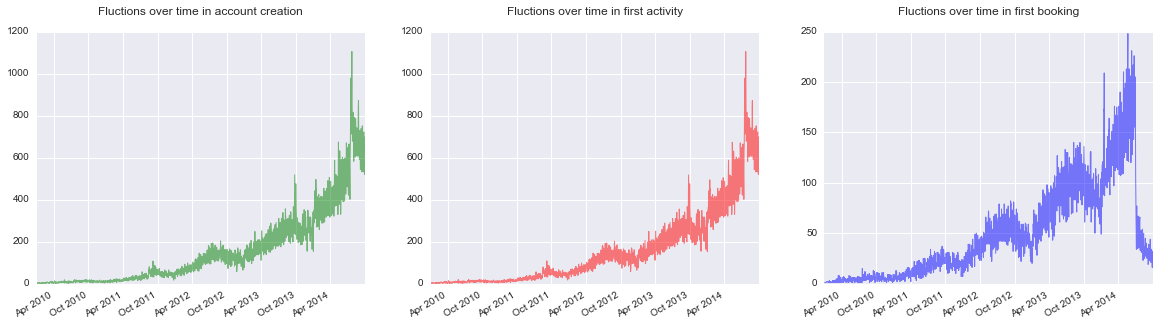

In [73]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
colours = ['g', 'r', 'b']
vars = ['date_account_created', 'date_first_active', 'date_first_booking']
titles = ['account creation', 'first activity', 'first booking']
for i, var in enumerate(vars):
    users[var].value_counts().plot(ax=axes[i], alpha=0.5, legend=False, lw=1, c=colours[i], 
                                   xlim=['2010-01-01','2014-09-30'])
    axes[i].set_title('Fluctions over time in %s\n' % titles[i])

From the graphs above and the correlation calulation below there is an exceptionall strong relationship between  the account creation date, the date of the first activity and first booking date (where the dates aren't null). This leads me to think that new users tend to join with the express purpose of making arangements for a trip, but only a bout a 5th of the time does this initial activity lead to the first booking in short sucession.

In [81]:
users['num_account_created'] = pd.to_numeric(users.date_account_created)
users['num_first_active'] = pd.to_numeric(users.date_first_active)
users['num_first_booking'] = pd.to_numeric(users.date_first_booking)

print users[['num_account_created', 'num_first_active']].corr()
print
print users[['num_account_created', 'num_first_booking']].corr()

                     num_account_created  num_first_active
num_account_created             1.000000          0.999479
num_first_active                0.999479          1.000000

                     num_account_created  num_first_booking
num_account_created             1.000000           0.968063
num_first_booking               0.968063           1.000000


Special Thanks to David Gasquez's excellent data exploration work
https://www.kaggle.com/davidgasquez/airbnb-recruiting-new-user-bookings/user-data-exploration/notebook